In [22]:
import numpy as np
import sys
sys.path.append('../lib/')
from utils import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

In [ ]:
# Image proportion referred to diameter, distances in pixels
D = 653.944097620
d = 216.6689743473
d1 = 290.176198804
d2 = 40.754174974
dx = 152.33333333
dy = 253.274184433
s = 6.969248238

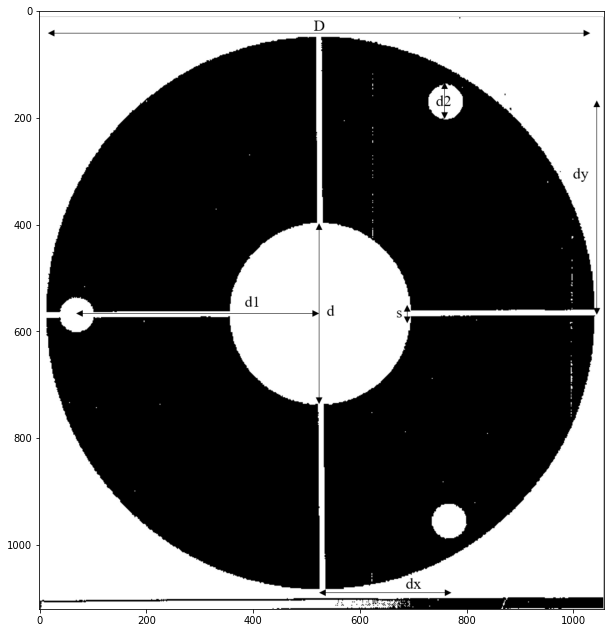

In [24]:
plt.figure(figsize=(15,11))
image = mpimg.imread("../Images/HST_measure.png")
imgplot = plt.imshow(image)
plt.show()

In [25]:
def get_rp(diameter, wavelentgh, N):
    Pixel_scale = 0.05 # in arcsec
    Pixel_rad = Pixel_scale * np.pi / (180 * 3600)  # arcsecs to rad
    u_cutoff = Diam / lamb
    Du = 1/(N * Pixel_rad)
    rp = u_cutoff / (2 * Du)
    return rp

In [26]:
Diam = 2.4 # metres  
lamb = 606E-9 # metres
N = 4096

rp = get_rp(Diam, lamb, N)
rp

1966.135482994712

In [27]:
def HST_pupil(CCD, *prop):
    """
    Parameters
    ----------
    CCD :: int, horizotal asnd vertical resolution
    prop  :: tuple, proportions of images distances
             r**p, D, d, d1, d2, dx, dy, s
             
    Retrun
    ------
    pupil :: numpy.ndarray, pupil's matrix of pixels 
    """  
    x = y = np.arange(0, CCD)
    pupil = np.zeros((CCD, CCD))
    rp, D, d, d1, d2, dx, dy, s = prop
    
    # Proportions
    s_prop = s / D * (2 * rp)
    d_prop = d / D * (2 * rp)
    d1_prop = d1 / D * (2 * rp)
    d2_prop = d2 / D * (2 * rp)
    x_prop = dx / D * (2 * rp)
    y_prop = dy / D * (2 * rp)
    
    # image center coordinates
    cx = cy = CCD // 2

    # outer full circle 
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < rp**2
    pupil[mask] = 1

    # cross
    pupil[int(cx - s_prop/2): int(cy + s_prop/2 + 1), :] = 0
    pupil[:, int(cx - s_prop/2): int(cy + s_prop/2 + 1)] = 0

    # inner circle
    r = d_prop//2
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0

    # bolt left 
    r = d2_prop//2
    cx = CCD//2 - int(d1_prop)
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0

    # bolt bottom right
    cx = CCD//2 + int(x_prop)
    cy = CCD//2 + int(y_prop)
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0

    # bolt top right
    cx = CCD//2 + int(x_prop)
    cy = CCD//2 - int(y_prop)
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0
    
    return pupil

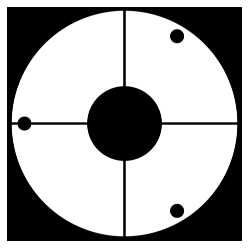

In [28]:
pupil = HST_pupil(N, rp, D, d, d1, d2, dx, dy, s)

fig, ax = latex_settings()
ax.imshow(pupil, cmap='gray')
ax.axis('off')
plt.savefig('../Images/Hubble_pupil.png', dpi=800, transparent=1)

Compute autocorrelation

In [14]:
# autocorrelation
res = signal.correlate(pupil, pupil, method='fft', mode='full')
# normalization
res = res/res.max()

In [15]:
# autocorrelation
res = signal.correlate(pupil, pupil, method='fft', mode='same')
# normalization
res = res/res.max()

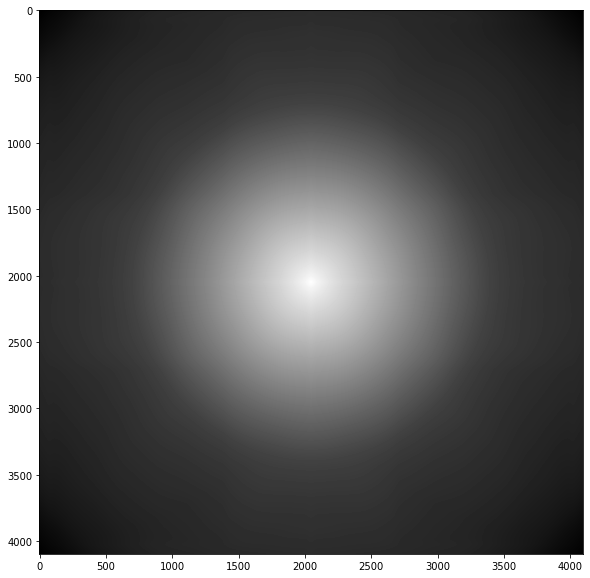

In [16]:
# print OTF
plt.figure(figsize=(10, 10))
plt.imshow(res, cmap='gray');

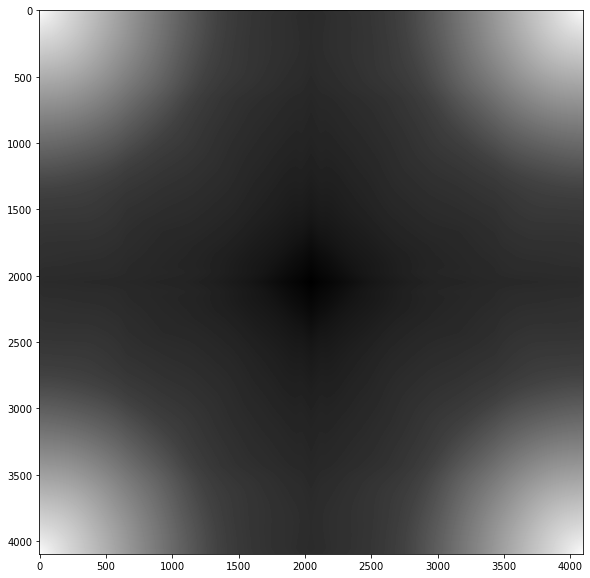

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(np.fft.fftshift(res), cmap='gray');

In [18]:
# shift max of frequecies at 0 for OTF
OTF_shift = np.fft.fftshift(res)
# Fourier antitransform of OTF
PSF = np.fft.ifft2(OTF_shift)
PSF = np.abs(PSF)
# shift back the PSF
PSF = np.fft.ifftshift(PSF)  #provare a non shiftare 

In [19]:
PSF.min(), PSF.max()

(2.9268758992731773e-16, 0.40218643415193456)

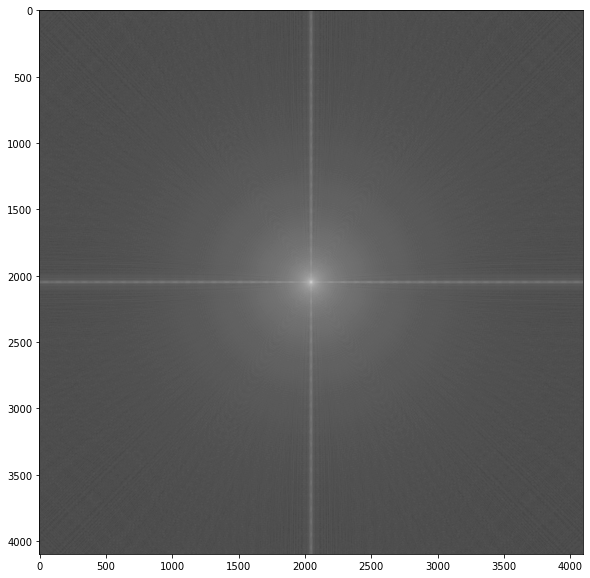

In [20]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(np.log(PSF), cmap='gray');

In [37]:
bb = 15

xc, yc = np.where(PSF==PSF.max())
xc, yc = xc[0], yc[0]
PSF_cut = PSF[yc-bb:yc+bb, xc-bb:xc+bb]

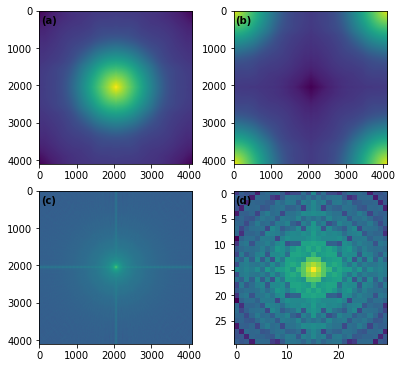

In [38]:
panels = ['(a)', '(b)', '(c)', '(d)']

fig, axs = latex_settings(2, 2, height=1.5)
axs[0, 0].imshow(res)
axs[0, 1].imshow(np.fft.fftshift(res))
axs[1, 0].imshow(np.log(PSF))
axs[1, 1].imshow(np.log(PSF_cut))

for i, ax in enumerate(axs.flatten()):
    # label physical distance in and down:
    ax.annotate(xy=(0.01, 0.97), text=panels[i], xycoords='axes fraction', 
            fontsize='medium', verticalalignment='top', weight='bold',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

#plt.savefig('../Images/process_Hubble_pupil_PSF.png', dpi=800, transparent=1)

In [14]:
filepath = '../Results/Hubble/'
np.save(file=filepath+'Hubble_pupil_PSF.npy', arr=PSF)

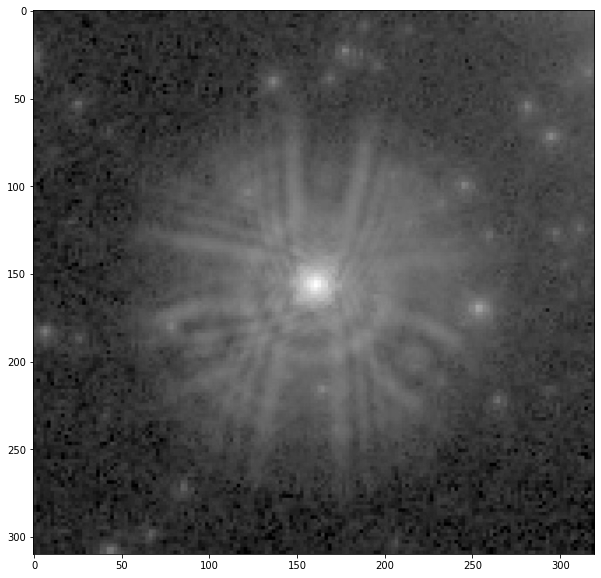

In [15]:
# PSF of Hubble telescope
plt.figure(figsize=(15, 10))
plt.imshow(mpimg.imread("../Immagini/Hubble_PSF_with_flawed_optics.jpg"), cmap='gray');

# References 
1. Hubble instrument [dimensions](https://www.teledyne-e2v.com/news/e2v-ccd-imaging-sensors-to-enable-nasas-hubble-space-telescope-to-explore-the-nature-and-history-of-our-universe-with-greater-capability-than-ever-before/)
2. Hubble instrument [caracteristics](https://hst-docs.stsci.edu/acsihb/chapter-3-acs-capabilities-design-and-operations/3-5-acs-quick-reference-guide)
3. Hubble [pupil](https://www.semanticscholar.org/paper/Hubble-Space-Telescope-prescription-retrieval.-Redding-Dumont/bd291aa8300cec9fb42e7ce549111b9dd4cc9e1a/figure/4) image
4. Hubble [PSF](https://en.wikipedia.org/wiki/Hubble_Space_Telescope#/media/File:Hubble_PSF_with_flawed_optics.jpg)